In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import calendar
#import prophet

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (10,8)

In [82]:
df = pd.read_csv("data/bikes.csv", index_col = 0 )

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(2)
memory usage: 97.0+ KB


In [84]:
df.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
519,520,04-06-2019,summer,1,6,0,1,1,1,24.497500,28.91415,48.7083,19.083811,1071,5927,6998
698,699,30-11-2019,winter,1,11,0,5,1,1,12.231653,16.19335,64.9583,3.917544,362,5306,5668
710,711,12-12-2019,winter,1,12,0,3,1,2,12.197500,14.86690,53.8333,10.916779,310,5009,5319
703,704,05-12-2019,winter,1,12,0,3,1,1,17.971653,21.40060,48.5000,21.709407,331,5398,5729
250,251,08-09-2018,autumn,0,9,0,4,1,3,25.990433,27.76805,93.9565,12.914116,153,1689,1842


- 1. En la columna yr, el 0 hace referencia a 2018 y el 1 2019 ---> cambiar a 2018 y 2019
- 2. Revisar estaciones segun meses - NO HECHO - Revisar para hacer la función con diccionario - día específico de la semana 😒
- 3. Los dias de la semana pasarlos a str (texto)
- 4. Redondear temperaturas
- 5. Cambiar dteday a tipo daytime DONE 
- 6. Comprobar festivos - columna holiday - 16 días
- 7. Los dias de la semana no corresponden con los que debieran ser 🤦‍♀️🤦‍♀️
- 8. librería prophet - solo festivos nacionales 👁️ hacer otro entorno
- 9. Librería calendar - dia de la semana DONE.
- 10. Chequear funcion seasons 

Weathersit :
- 1: Sol y nubes
- 2: Niebla - nublado
- 3: Regulinchi
- 4: Tiempo chungo

In [85]:
df.duplicated().sum()

0

In [86]:
df.shape

(730, 16)

In [87]:
#Cambiar columna 'dteday' a datatime

df.dteday =pd.to_datetime(df.dteday, dayfirst=True)

In [88]:
primavera = df[df['season']=='spring'] #Primavera 20 marzo - 21 junio
primavera['mnth'].unique()

array([ 1,  2,  3, 12])

In [89]:
invierno = df[df['season']=='winter'] # Invierno 21 de diciembre - 20 de marzo
invierno['mnth'].unique()

array([ 9, 10, 11, 12])

In [90]:
#Verano 21 junio - 23 septiembre 
verano = df[df['season']=='summer'] 
verano['mnth'].unique()

array([3, 4, 5, 6])

In [91]:
#Otoño 23 septiembre - 21 de diciembre
otoño = df[df['season']=='autumn'] 
otoño['mnth'].unique()

array([6, 7, 8, 9])

In [100]:
df[df['dteday']> '2018']
df.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349


In [93]:
#Primavera 21 marzo - 20 junio
#Verano 21 junio - 22 septiembre 
#Otoño 23 septiembre - 20 de diciembre
#Invierno 21 de diciembre - 20 de marzo

In [113]:
def seasons (col):
  years=['2018','2019']
  
  for year in years:
    seasons = {'spring':pd.date_range(start= (year) + '-03-21', end= (year) + '-06-20')}
            #'summer':pd.date_range(inicio= f'{year}-06-21', fin= f'{year}-09-22'),
            #'autumn':pd.date_range(inicio= f'{year}-09-23', fin= f'{year}-12-20'),
            #'winter':pd.date_range(inicio= f'{year}-09-23', fin= f'{year}-012-20')}
    if col in seasons.values():
      print(col)
      return seasons.keys()

    #return

In [114]:
seasons(df['dteday'])

NameError: name 'years' is not defined

In [ ]:
#ENLACE ENVIADO POR NATALIA

pd.date_range(start='1/1/2018', periods=5, freq='3M')
DatetimeIndex(['2018-01-31', '2018-04-30', '2018-07-31', '2018-10-31',
               '2019-01-31'],
              dtype='datetime64[ns]', freq='3M')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    object        
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
 16  seasons_ok  730 non-null  

In [ ]:
#Hacemos una función para reasignar correctamente los meses con las estaciones

# def estaciones(col):
#     #diccionario = {'winter': [1, 2, 3], 'spring': [4, 5, 6]}
#     if col == 1:
#         return 'winter'
#     elif col == 2:
#         return 'winter'
#     elif col == 3:
#         return 'winter'
#     elif col == 4:
#         return 'spring'
#     elif col == 5:
#         return 'spring'
#     elif col == 6:
#         return 'spring'
#     elif col == 7:
#         return 'summer'
#     elif col == 8:
#         return 'summer'
#     elif col == 9:
#         return 'summer'
#     elif col == 10:
#         return 'autumn' 
#     elif col == 11:
#         return 'autumn'
#     else:
#         return 'autumn'

In [ ]:
#df['seasons_ok'] = df['mnth'].apply(estaciones)

In [ ]:
df['seasons_ok'].unique()

array(['winter', 'spring', 'summer', 'autumn'], dtype=object)

In [ ]:
df.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,seasons_ok
214,215,03-08-2018,autumn,0,8,0,3,1,2,29.998347,33.99685,65.7500,9.084061,467,3107,3574,summer
211,212,31-07-2018,autumn,0,7,0,0,0,1,33.039153,36.48980,48.0833,11.042471,1524,2778,4302,summer
334,335,01-12-2018,winter,0,12,0,4,1,1,12.812500,15.27770,52.4583,14.750586,182,3545,3727,autumn
219,220,08-08-2018,autumn,0,8,0,1,1,1,31.365000,35.16415,59.2083,12.875725,846,3480,4326,summer
723,724,25-12-2019,spring,1,12,1,2,0,2,11.943464,14.72325,73.4783,11.304642,440,573,1013,autumn


In [ ]:
df.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [ ]:
festivos = df[df['holiday']== 1]

In [ ]:
festivos.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
16,17,17-01-2018,spring,0,1,1,1,0,2,7.209153,8.83855,53.7500,12.999139,117,883,1000
51,52,21-02-2018,spring,0,2,1,1,0,2,12.436653,14.20375,60.5000,20.625682,195,912,1107
104,105,15-04-2018,summer,0,4,1,5,0,1,18.313347,22.09565,67.1250,15.167125,642,2484,3126
149,150,30-05-2018,summer,0,5,1,1,0,1,30.066653,33.55460,68.5000,8.792075,1549,2549,4098
184,185,04-07-2018,autumn,0,7,1,1,0,2,29.793347,33.27085,63.7917,5.459106,3065,2978,6043


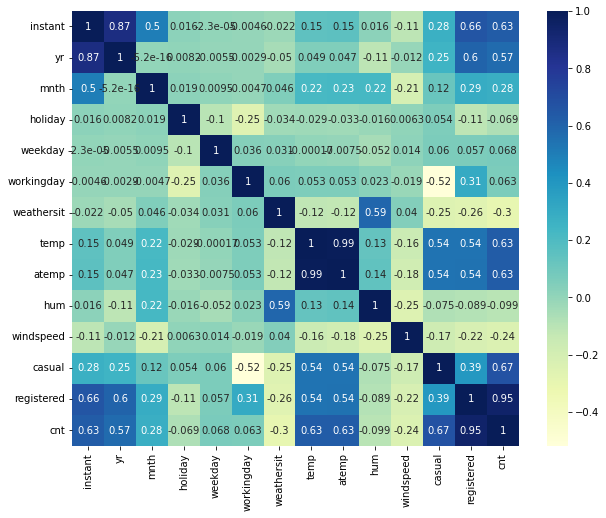

In [ ]:

sns.heatmap(df.corr(), 
            cmap = "YlGnBu", 
           annot = True);

In [ ]:
df.tail(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,seasons_ok
720,721,2019-12-22,spring,1,12,0,6,0,1,10.899153,11.80565,44.1250,27.292182,205,1544,1749,autumn
721,722,2019-12-23,spring,1,12,0,0,0,1,10.079153,12.97355,51.5417,8.916561,408,1379,1787,autumn
722,723,2019-12-24,spring,1,12,0,1,1,2,9.483464,12.94500,79.1304,5.174437,174,746,920,autumn
723,724,2019-12-25,spring,1,12,1,2,0,2,11.943464,14.72325,73.4783,11.304642,440,573,1013,autumn
724,725,2019-12-26,spring,1,12,0,3,1,3,9.976653,11.01665,82.3333,21.208582,9,432,441,autumn
725,726,2019-12-27,spring,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114,autumn
726,727,2019-12-28,spring,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095,autumn
727,728,2019-12-29,spring,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341,autumn
728,729,2019-12-30,spring,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796,autumn
729,730,2019-12-31,spring,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729,autumn


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    object        
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
 16  seasons_ok  730 non-null  

In [ ]:
df.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,seasons_ok
469,470,2019-04-15,summer,1,4,0,0,0,1,24.873347,28.69375,50.7917,15.083643,2846,4286,7132,spring
504,505,2019-05-20,summer,1,5,0,0,0,1,25.454153,29.19835,53.0417,17.042589,2704,4425,7129,spring
533,534,2019-06-18,summer,1,6,0,1,1,2,23.301653,27.24210,77.7917,11.707982,653,4446,5099,spring
268,269,2018-09-26,winter,0,9,0,1,1,2,26.615847,29.45210,84.8333,7.416900,684,3946,4630,summer
656,657,2019-10-19,winter,1,10,0,5,1,2,23.096653,26.89480,81.5000,9.041918,753,4671,5424,autumn


In [ ]:
# Identificar los dias exactos por season 
festivos =[]

